## Scenario & dataset

This dataset features traffic captured between a thermostat (2001:db8:a::3) and an application server (2001:db8:a::20).

The protocol stack used for this communication is based on IPv6, UDP, CoAP for all datagrams. 

At the application level, two formats are being used : 

- Lightweight M2M TLV format
- CBOR encoding format

3 lw-M2M resources are described:

- a temperature sensor (resource ID `3303`)
- a humidity sensor (resource ID `3304`) 
- a setpoint (resource ID `3308`).


The following resource IDs of the temperature and humidity sensors are used in the dataset:

- sensor value (resource ID `5700`)
- min measured value (resource ID `5601`)
- max measured value (resource ID `5602`)
- min range value (resource ID `5603`)
- max range value (resource ID `5604`)
- sensor units (resource ID `5701`)

A reset of the min/max measured values is triggered using the resource ID `5605`.


The following resource IDs of the setpoint are used in the dataset:

- setpoint value (resource ID `5900`)
- sensor units (resource ID `5701`)
- color (resource ID `5706`)
- application type (resource ID `5750`)
- timestamp (resource ID `5518`)
- fractional timestamp (resource ID `6050`)

### Traffic characteristics

The dominant traffic is from the device (client) to the server ( `2001:db8::3` -> `2001:db8::20`) and the most frequent packets are readings from sensors, i.e. CoAP code `2.05` (content) & resource ID `5700` (sensor value).
Notice the repeating CoAP Token values, e.g. `d159`, `2150`, `8d43`, `3709` and `1f0a`, each corresponding to an observe subscription, as described in Fig. 1.

![Fig 1. Observe traffic pattern](dataset/thermostat/observe-pattern.png)

The server subscribes with an observe request to a resource whose value he wants to track (such as the temperature and humidity value, min and max). Tracked resources periodically send updates through notifications. Notifications are usually sent without confirmation (NON) but once in a while they are sent as confirmed messages (CON). The server then sends an empty ACK (no token) with the same message ID as the confirmed message. 
The dataset includes notifications using two different formats: the first one has values in lwm2m+tlv and the second one in cbor. In addition, these messages feature an observe sequence number which starts from 1 and is incremented at each new packet. Initially, it is encoded on 1 byte, then when the value exceeds xff, it switches to 2 bytes, and so on.

In [10]:
from typing import List
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
from tools.pcapng import packets_list
from microschc.rfc8724extras import Context
from microschc.parser import PacketParser
from microschc.binary import Buffer
from microschc.protocol.ipv6 import IPv6Parser
from microschc.protocol.udp import UDPParser
from microschc.protocol.coap import CoAPParser, CoAPOptionMode

In the following, let us identify the packet structures (templates) which will serve as a basis for building SCHC rules.



In [11]:
DATASET = 'dataset/thermostat/leshan-thermostat-readings.pcapng'
SYNTACTIC_CONTEXT_FILEPATH = 'dataset/thermostat/syntactic.json'
SEMANTIC_CONTEXT_FILEPATH = 'dataset/thermostat/semantic.json'

with open(SYNTACTIC_CONTEXT_FILEPATH, mode='r') as f:
        syntactic_context_json = f.read()

with open(SEMANTIC_CONTEXT_FILEPATH, mode='r') as f:
    semnantic_context_json = f.read()

    
syntactic_context: Context = Context.from_json(json_str=syntactic_context_json)
semantic_context: Context = Context.from_json(json_str=semnantic_context_json)

syntactic_parser: PacketParser = PacketParser('syntactic', parsers=[
    IPv6Parser(),
    UDPParser(),
    CoAPParser(interpret_options=CoAPOptionMode.SYNTACTIC)
])

semantic_parser: PacketParser = PacketParser('semantic', parsers=[
    IPv6Parser(),
    UDPParser(),
    CoAPParser(interpret_options=CoAPOptionMode.SEMANTIC)
])

packets:List[Buffer] = packets_list(DATASET)
print(f'dataset size: {len(packets)} packets')

dataset size: 10000 packets


# Dataset statistics

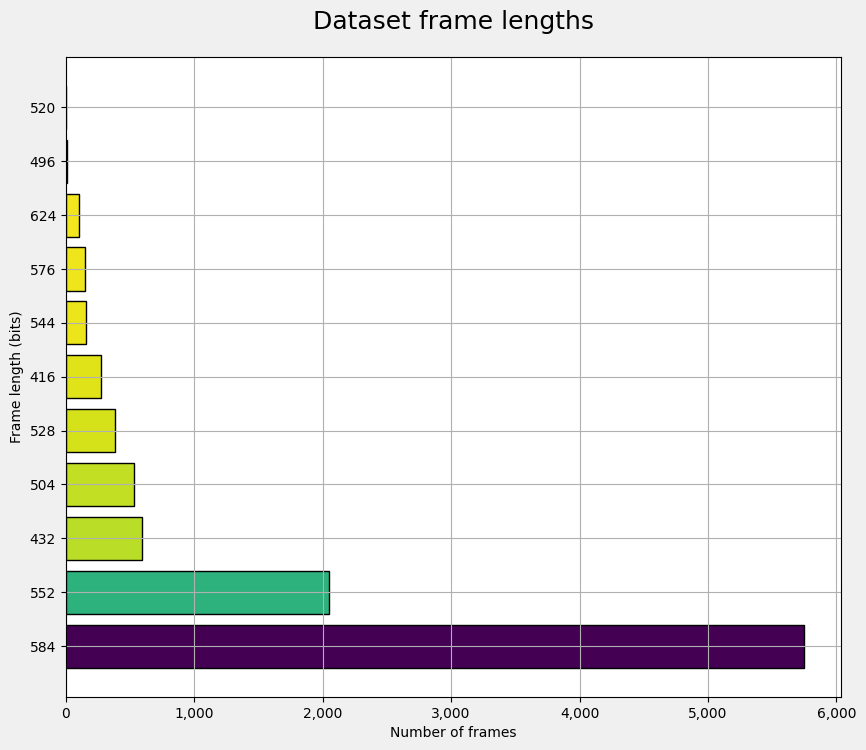

In [12]:

number_of_packets: int = len(packets)
lengths_of_packets: List[int] = [packet.length for packet in packets]
total_length: int = sum(lengths_of_packets)

lengths_counter: Counter = Counter(lengths_of_packets)
            
fig, ax = plt.subplots(figsize=(10,8), facecolor=(.94, .94, .94))
    
# Variables
sorted_lengths = lengths_counter.most_common()
plot_title = 'Dataset frame lengths'
title_size = 18
x_label = 'Number of frames'
y_label = 'Frame length (bits)'


labels = [f'{sl[0]}' for sl in sorted_lengths]
widths = [sl[1] for sl in sorted_lengths]

color_widths = [max(widths)-w for w in widths]
norm = plt.Normalize(min(widths), max(widths))
colors = plt.cm.viridis(norm(color_widths))

bar = plt.barh(labels, widths, color=colors, edgecolor='black')
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
            
title = plt.title(plot_title, pad=20, fontsize=title_size)
title.set_position([.5, 1])
plt.subplots_adjust(top=0.9, bottom=0.1)


ax.grid(zorder=0)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)


plt.show()

# Syntactic approach statistics

In [13]:
from template import Template, template_as_asciitable

syntactic_templates: List[Template] = Template.find_templates(packets, parser=syntactic_parser)
print(f'Syntactic approach: {len(syntactic_templates)} templates')
for i, template in enumerate(syntactic_templates):
    print(f'template {i}: {len(template.fields)} fields, {len(template.packet_descriptors)} packets, average length: {sum([pd.length for pd in template.packet_descriptors])/len(template.packet_descriptors):.2f}')
    
print(f'most common template:\n{template_as_asciitable(syntactic_templates[0])}')



Syntactic approach: 6 templates
template 0: 25 fields, 1 packets, average length: 576.00
template 1: 27 fields, 1 packets, average length: 528.00
template 2: 18 fields, 1 packets, average length: 432.00
template 3: 31 fields, 1 packets, average length: 624.00
template 4: 24 fields, 1 packets, average length: 544.00
template 5: 17 fields, 1 packets, average length: 416.00
most common template:
+----------------------------+-----------------------------------------------+
|          field ID          |                    length                     |
+============================+===============================================+
| 0-IPv6:Version             | 1 value of size: (4)                          |
|                            | [----0110 ](4): 8544                          |
+----------------------------+-----------------------------------------------+
| 1-IPv6:Traffic Class       | 1 value of size: (8)                          |
|                            | [00000000](8): 8544 

# Semantic approach statistics

In [5]:
from template import Template, template_as_asciitable

semantic_templates: List[Template] = Template.find_templates(packets, parser=semantic_parser)
print(f'Semantic approach: {len(semantic_templates)} templates')
for i, template in enumerate(semantic_templates):
    print(f'template {i}: {len(template.fields)} fields, {len(template.packet_descriptors)} packets, average length: {sum([pd.length for pd in template.packet_descriptors])/len(template.packet_descriptors):.2f}')
    
print(f'most common template:\n{template_as_asciitable(semantic_templates[0])}')


Semantic approach: 6 templates
template 0: 21 fields, 1 packets, average length: 576.00
template 1: 21 fields, 1 packets, average length: 528.00
template 2: 18 fields, 1 packets, average length: 432.00
template 3: 23 fields, 1 packets, average length: 624.00
template 4: 20 fields, 1 packets, average length: 544.00
template 5: 17 fields, 1 packets, average length: 416.00
most common template:
+---------------------------------+-----------------------------------------------+
|            field ID             |                    length                     |
+=================================+===============================================+
| 0-IPv6:Version                  | 1 value of size: (4)                          |
|                                 | [----0110 ](4): 8544                          |
+---------------------------------+-----------------------------------------------+
| 1-IPv6:Traffic Class            | 1 value of size: (8)                          |
|                

# Syntactic rules

In [14]:
    
from tools.ascii import rule_descriptor_as_ascii_table


for rule in syntactic_context.ruleset:
    print(f'rule: {rule.id}')
    print(rule_descriptor_as_ascii_table(rule))

rule: [----0000 ](4)
+----------------------------+-----+----+--------+-----------------------------------------+
|            FID             | LEN | FD | MO/CDA |                   TV                    |
+============================+=====+====+========+=========================================+
| 0-IPv6:Version             | 4   | Bi | eq/ns  | [----0110 ](4)                          |
+----------------------------+-----+----+--------+-----------------------------------------+
| 1-IPv6:Traffic Class       | 8   | Bi | ig/ns  | [00000000](8)                           |
+----------------------------+-----+----+--------+-----------------------------------------+
| 2-IPv6:Flow Label          | 20  | Bi | eq/ns  | [0ff85f](20)                            |
+----------------------------+-----+----+--------+-----------------------------------------+
| 3-IPv6:Payload Length      | 16  | Bi | ig/co  | [](0)                                   |
+----------------------------+-----+----+--------

In [9]:
for rule in semantic_context.ruleset:
    print(rule)

[[----0000 ](4)](21) {IPv6:Version(4):eq/ns|[----0110 ](4)}|{IPv6:Traffic Class(8):ig/ns|[00000000](8)}|{IPv6:Flow Label(20):eq/ns|[0ff85f](20)}|{IPv6:Payload Length(16):ig/co|[](0)}|{IPv6:Next Header(8):eq/ns|[00010001](8)}|{IPv6:Hop Limit(8):eq/ns|[01000000](8)}|{IPv6:Source Address(128):eq/ns|[20010db8000a00000000000000000003](128)}|{IPv6:Destination Address(128):eq/ns|[20010db8000a00000000000000000020](128)}|{UDP:Source Port(16):eq/ns|[10010000 10100000](16)}|{UDP:Destination Port(16):eq/ns|[00010110 00110011](16)}|{UDP:Length(16):ig/co|[](0)}|{UDP:Checksum(16):ig/co|[](0)}|{CoAP:Version(2):eq/ns|[------01 ](2)}|{CoAP:Type(2):ms/ls|[ 0-------](1)}|{CoAP:Token Length(4):eq/ns|[----0010 ](4)}|{CoAP:Code(8):eq/ns|[01000101](8)}|{CoAP:Message ID(16):ig/vs|[](0)}|{CoAP:Token(16):ig/vs|[](0)}|{CoAP:Option Unknown(6)(0):ig/ns|[](0)}|{CoAP:Option Content-Format(0):ig/ns|[00101101 00010110](16)}|{CoAP:Payload Marker(8):eq/ns|[11111111](8)}
[[----0001 ](4)](18) {IPv6:Version(4):eq/ns|[----01